## Celem jest predykcja wysokości odszkodowania z tytułu ubezpieczenia

In [31]:
pip install hyperopt

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [32]:
import helper as h

import importlib
importlib.reload(h)

import pandas as pd
import numpy as np
np.random.seed(2019)

from sklearn.preprocessing import minmax_scale

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
train = pd.read_csv('/Users/patrycjapiechowicz/Downloads/allstate.train.csv')

In [34]:
train.info()
#train.info(max_cols=140)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [35]:
train.columns.values

array(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14',
       'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21',
       'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28',
       'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35',
       'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42',
       'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49',
       'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56',
       'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63',
       'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70',
       'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77',
       'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84',
       'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91',
       'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98',
       'cat99', 'cat100

In [6]:
train.sample(10)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
150091,468008,A,A,A,A,B,A,A,A,A,...,0.879507,0.856216,0.28768,0.64296,0.83510,0.784967,0.785706,0.837535,0.708622,2129.69
8652,27472,A,A,A,B,B,B,A,A,A,...,0.544630,0.425088,0.67787,0.79047,0.60932,0.592525,0.579845,0.723122,0.802008,8289.68
103918,324684,A,B,A,B,A,A,A,A,B,...,0.416181,0.349614,0.62918,0.50630,0.37493,0.338312,0.338446,0.315758,0.488121,4606.95
134811,420588,A,A,A,A,B,A,A,A,A,...,0.364464,0.365369,0.24564,0.32865,0.40666,0.245410,0.241676,0.624025,0.540100,4103.90
104982,327919,A,B,A,B,B,A,A,A,B,...,0.314430,0.251752,0.44697,0.42289,0.26029,0.192281,0.190178,0.470036,0.235522,2958.38
72648,227029,A,A,A,A,B,B,A,A,A,...,0.342167,0.291170,0.34987,0.31945,0.22755,0.275431,0.270746,0.503333,0.247853,2664.86
76605,239586,A,A,A,A,B,A,A,A,A,...,0.722158,0.591403,0.71817,0.64873,0.74396,0.698978,0.685713,0.689974,0.836878,1347.73
184432,575483,A,B,A,A,B,A,A,A,B,...,0.557431,0.402942,0.34445,0.52728,0.79139,0.377724,0.369858,0.687115,0.801539,3463.32
178171,555969,A,A,A,B,A,B,A,A,A,...,0.278408,0.308363,0.29260,0.24958,0.27777,0.180456,0.178698,0.310026,0.230296,1202.91
180802,564100,A,B,A,A,A,A,A,A,B,...,0.233692,0.244789,0.70342,0.30859,0.21230,0.197173,0.194925,0.417430,0.660063,2331.47


In [36]:
if 'id' in train: del train['id']

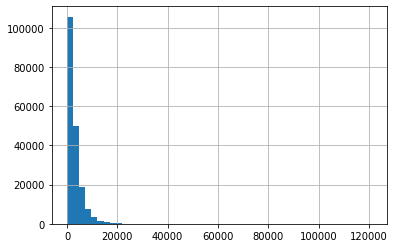

In [37]:
#target
train['loss'].hist(bins=50);

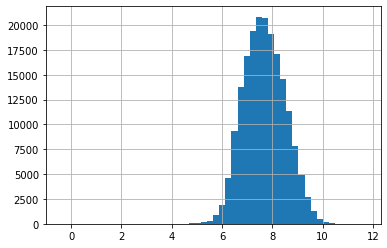

In [38]:
train['log_loss'] = np.log( train['loss'] )
train['log_loss'].hist(bins=50);

### Basic Model

In [39]:
X, y = train[ ['cont1'] ], train['loss'].values

model = DummyRegressor()
model.fit(X, y)
y_pred = model.predict(X)

mean_absolute_error(y, y_pred)

1966.1652855607203

In [40]:
train.select_dtypes(include=[np.number]).columns.values

array(['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14',
       'loss', 'log_loss'], dtype=object)

In [41]:
def get_feats(df):
    black_list = ['loss', 'log_loss']
    feats = df.select_dtypes(include=[np.number]).columns.values
    
    feats = [feat for feat in feats if feat not in black_list]
    return feats
    
def get_X_y(df, target='loss', verbose=False):
    feats = get_feats(df)
    if verbose: print(feats)
        
    X = df[ get_feats(df) ].values
    y = df[target].values
    
    return X, y

X, y = get_X_y(train)

In [42]:
def run_cv(X, y, model, folds=3):
    cv = KFold(n_splits=folds, shuffle=True, random_state=0)

    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)


def run_log_cv(X, y, model, folds=3, shift = 1):
    y_log = np.log(y + shift)
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=0)

    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y_log[train_idx])
        y_log_pred = model.predict(X[test_idx])
        y_log_pred[ y_log_pred < 0 ] = 1e-6
        
        y_pred = np.exp( y_log_pred ) - shift

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)

### Linear Regression

In [43]:
run_cv(X, y, LinearRegression(), folds=3)

(1950.609314518282, 5.26358554128097)

### Decision Tree Regressor

In [44]:
run_cv(X, y, DecisionTreeRegressor(max_depth=5))

(1937.9872302392569, 7.785759849307944)

### Random Forest Regressor

In [16]:
run_cv(X, y, RandomForestRegressor(max_depth=5, n_estimators=20))

(1931.9824319465795, 5.043444168409942)

### Extra Trees Regressor

In [17]:
run_cv(X, y, ExtraTreesRegressor(max_depth=5, n_estimators=20))

(1936.8722319157778, 5.970205891156901)

### Feature Engineering


In [45]:
num_feats = [feat for feat in train.columns if 'cont' in feat]
cat_feats = [feat for feat in train.columns if 'cat' in feat]

cat_id_feats = []
for feat in tqdm(cat_feats):
    feat_id = feat + '_id'
    train[feat_id] = train[feat].factorize()[0]
    cat_id_feats.append(feat_id)

100%|██████████| 116/116 [00:01<00:00, 65.04it/s]


In [46]:
X, y = get_X_y(train)

In [47]:
run_cv(X, y, DecisionTreeRegressor(max_depth=5))

(1455.7922247286867, 1.4573324856139513)

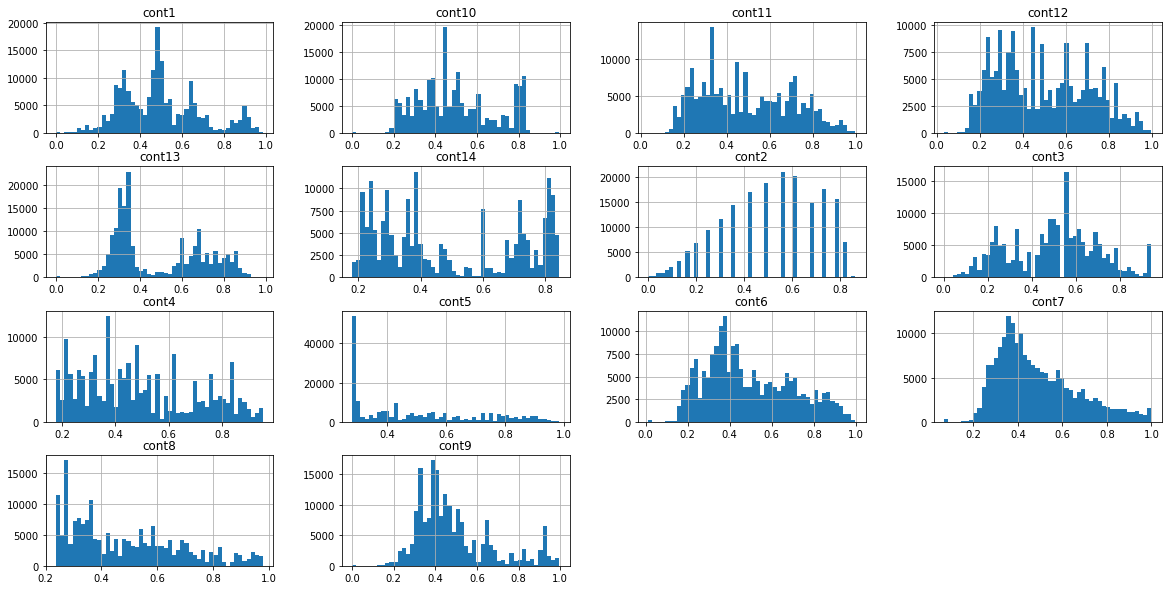

In [49]:
train[num_feats].hist(figsize=(20, 10), bins=50);

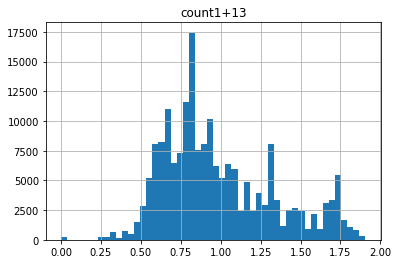

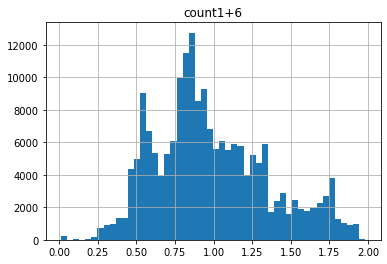

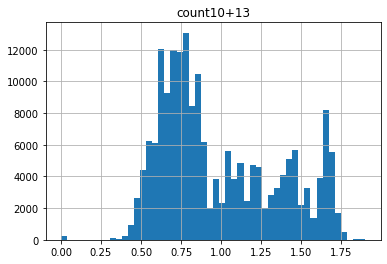

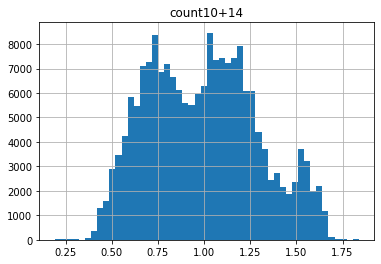

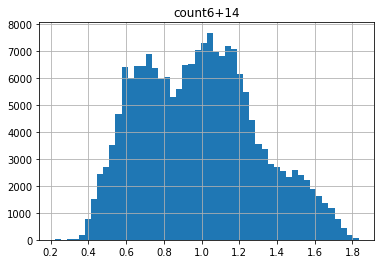

In [50]:
sum_pairs = [
    (1, 13),
    (1, 6),
    (10, 13),
    (10, 14),
    (6, 14),
]
sum_feats = []

for left, right in sum_pairs:
    output_idx = 'count{0}+{1}'.format(left, right)
    train[output_idx] = train['cont{0}'.format(left)] + train['cont{0}'.format(right)]
    sum_feats.append(output_idx)
    
    train[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

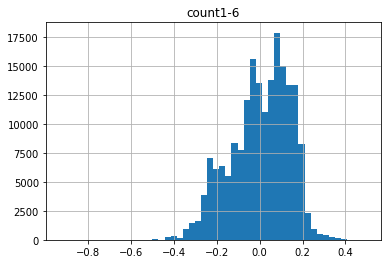

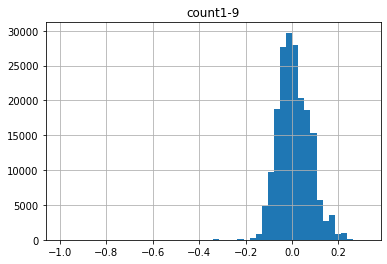

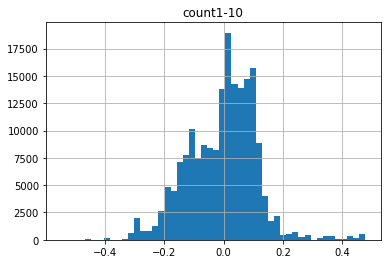

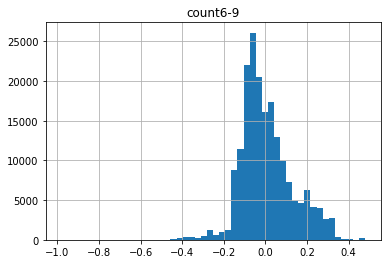

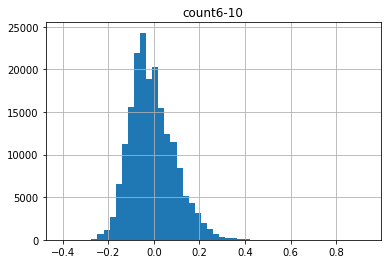

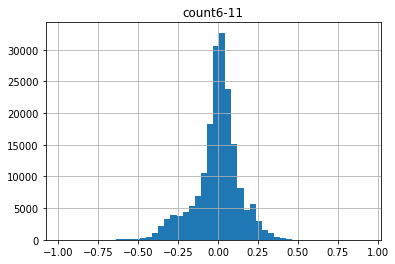

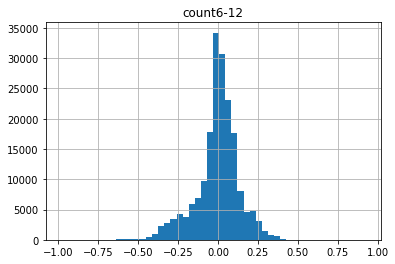

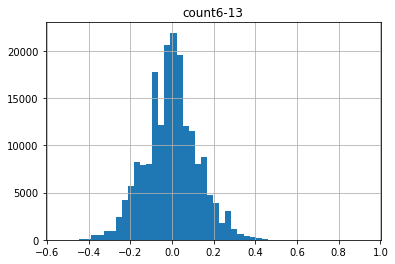

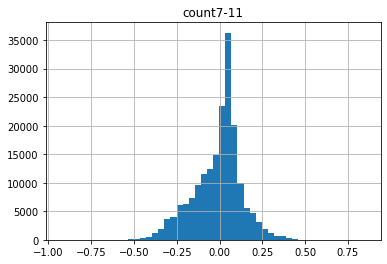

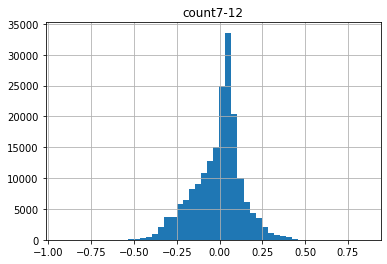

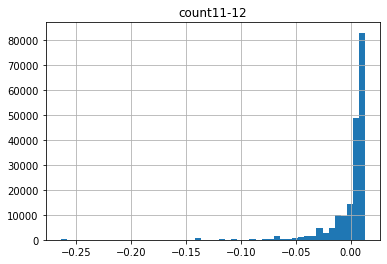

In [51]:
minus_pairs = [
    (1, 6),
    (1, 9),
    (1, 10),
    (6, 9),
    (6, 10),
    (6, 11),
    (6, 12),
    (6, 13),
    (7, 11),
    (7, 12),
    (11, 12)
]

minus_feats = []
for left, right in minus_pairs:
    output_idx = 'count{0}-{1}'.format(left, right)
    train[output_idx] = train['cont{0}'.format(left)] - train['cont{0}'.format(right)]
    minus_feats.append(output_idx)
    
    train[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

### Feature Importance

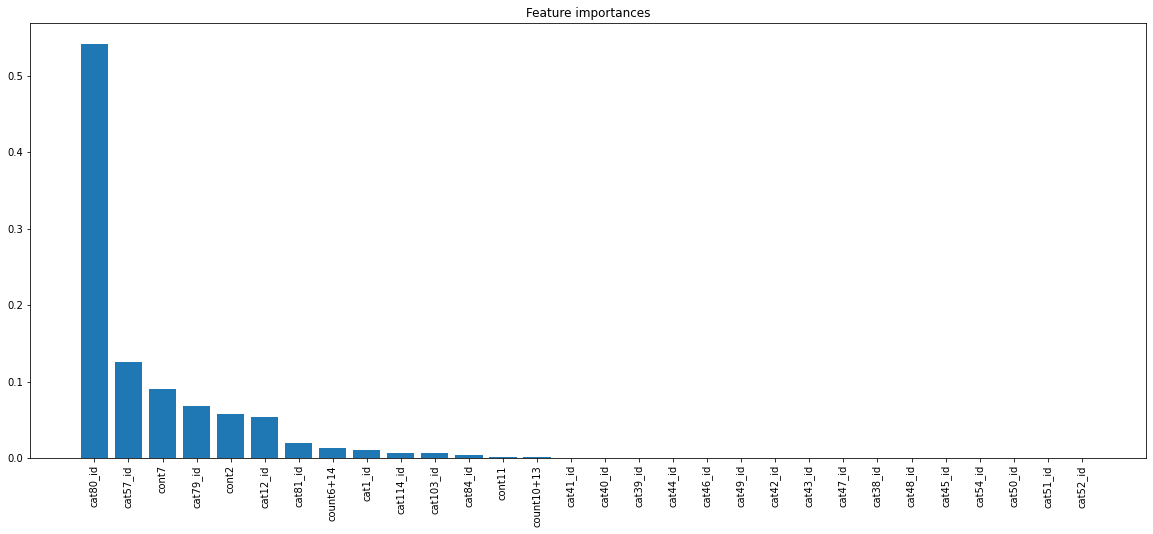

In [52]:
feats = cat_id_feats + num_feats + sum_feats + minus_feats
X = train[feats].values

model = DecisionTreeRegressor(max_depth=5)
model.fit(X, y)

h.plot_feature_importances(model, feats, limit=30)

In [ ]:
feats = cat_id_feats + num_feats + sum_feats + minus_feats
X = train[feats].values

model = RandomForestRegressor(max_depth=5, n_estimators=20)
model.fit(X, y)

h.plot_feature_importances(model, feats, limit=30)

In [ ]:
def plot_cat_var_and_loss(cat_id):
    print( train[cat_id].value_counts() )
    print( train[cat_id].value_counts(normalize=True) )

    train[cat_id].hist()
    plt.show()

    print("Loss")
    plt.figure(figsize=(20, 8))
    for i in range(4):
        plt.subplot(221 + i)
        plt.boxplot( train[ train[cat_id] == i ]['loss'] )
        plt.title(cat_id + ' == {0}'.format(i))

    plt.show();

    print("Log Loss")
    plt.figure(figsize=(20, 8))
    for i in range(4):
        plt.subplot(221 + i)
        plt.boxplot( train[ train[cat_id] == i ]['log_loss'] )
        plt.title(cat_id + ' == {0}'.format(i))
        plt.ylim(0, 12)

    plt.show();

In [ ]:
plot_cat_var_and_loss('cat80_id')

In [ ]:
plot_cat_var_and_loss('cat57_id')

In [ ]:
plot_cat_var_and_loss('cat79_id')

#### There is a lot of outliers, let's try with log

In [ ]:
X = train[ cat_id_feats + num_feats + sum_feats + minus_feats  ].values

run_log_cv(X, y, DecisionTreeRegressor(max_depth=5))

### XGB

In [ ]:
X = train[ cat_id_feats + num_feats + sum_feats + minus_feats  ].values
run_cv(X, y, xgb.XGBRegressor(objective='reg:squarederror'))

In [ ]:
shift = 1
def eval_mae(y_pred_log, dtrain):
    y      = np.exp(dtrain.get_label()) - shift
    y_pred = np.exp(y_pred_log) - shift
    
    return 'mae', mean_absolute_error(y,y_pred)

In [ ]:
def plot_xgb_learning_curve(train_evals, test_evals):
    mean_train_evals = np.mean(train_evals, axis=0)
    std_train_evals = np.std(train_evals, axis=0)

    mean_test_evals = np.mean(test_evals, axis=0)
    std_test_evals = np.std(test_evals, axis=0)

    plt.figure(figsize=(15, 5))

    plt.fill_between(range(len(mean_train_evals)), mean_train_evals - std_train_evals*3,
                     mean_train_evals + std_train_evals*3, alpha=0.1,
                     color="r")

    plt.fill_between(range(len(mean_test_evals)), mean_test_evals - std_test_evals*3,
                     mean_test_evals + std_test_evals*3, alpha=0.1,
                     color="g")


    plt.plot(mean_train_evals, label='train', c='r')
    plt.plot(mean_test_evals, label='test', c='g')
    plt.legend(loc='best')
    plt.title("Learning curve")
    plt.xlabel("# iterations")
    plt.ylabel("mae")
    plt.show()
    
    
def cv_xgb(df, feats, xgb_params, shift=1, folds=3, verbose=False, early_stopping_rounds=5, plot_lc=True, return_model=False):
    X = df[ feats ].values
    y = df['loss'].values
    y_log = np.log( y + shift )
    
    cv = KFold(n_splits=3, shuffle=True, random_state=2019)

    scores = []
    train_evals, test_evals = [], []
    for train_idx, test_idx in tqdm( cv.split(X) ):

        model = xgb.XGBRegressor(**xgb_params)
        eval_set = [ (X[train_idx], y_log[train_idx]), (X[test_idx], y_log[test_idx]),  ]
        model.fit(X[train_idx], y_log[train_idx], eval_metric=eval_mae, eval_set=eval_set, verbose=verbose, early_stopping_rounds=early_stopping_rounds)
        y_pred_log = model.predict(X[test_idx])
        y_pred_log[ y_pred_log < 0 ] = 1e-6
        y_pred = np.exp( y_pred_log ) - shift

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
        
        evals_result = model.evals_result()

        if plot_lc:
            train_evals.append( evals_result['validation_0']['mae'] )
            test_evals.append( evals_result['validation_1']['mae'] )

    if plot_lc:
        def norm_rows(rows):
            min_rows = min( [len(x) for x in rows])
            return [x[:min_rows] for x in rows]

        plot_xgb_learning_curve(norm_rows(train_evals), norm_rows(test_evals))
        
    if return_model:
        return model, np.mean(scores), np.std(scores)
    
    return np.mean(scores), np.std(scores)

In [ ]:
feats = num_feats + cat_id_feats + sum_feats + minus_feats

xgb_params = {
    'n_estimators': 50,
    'max_depth': 10,
    'learning_rate': 0.3,
    'random_state': 2019,
    'objective': 'reg:squarederror'
}
cv_xgb(train, feats, xgb_params, shift=shift)

### Normalize `numerical` variables

In [ ]:
all_cont_feats = [feat for feat in train.columns if feat.startswith('cont')]
[ (feat, train[feat].skew()) for feat in all_cont_feats ]

In [ ]:
for feat in tqdm(all_cont_feats):
    if train[feat].skew() < 0.25: continue
    train[feat + '_sqrt'] = np.sqrt( minmax_scale(train[feat]) )
    train[feat + '_log1p'] = np.log1p( minmax_scale(train[feat]) )
    
sqrt_cont_feats = [feat for feat in train.columns if feat.startswith('cont') and 'sqrt' in feat]
log_cont_feats = [feat for feat in train.columns if feat.startswith('cont') and 'log' in feat]

In [ ]:
feats = num_feats + cat_id_feats + sum_feats + minus_feats + sqrt_cont_feats + log_cont_feats

xgb_params = {
    'n_estimators': 50,
    'max_depth': 10,
    'learning_rate': 0.3,
    'random_state': 0,
    'objective': 'reg:squarederror',
}
cv_xgb(train, feats, xgb_params, shift=1)

In [ ]:
#shift
plt.figure(figsize=(20, 5))
plt.subplot(131)
np.log( train['loss'] ).hist(bins=50)
plt.title('log(loss)')

plt.subplot(132)
np.log( train['loss'] + 100).hist(bins=50)
plt.title('log(loss + 100)')

plt.subplot(133)
np.log( train['loss'] + 200).hist(bins=50)
plt.title('log(loss + 200)');

In [ ]:
cv_xgb(train, feats, xgb_params, shift=200)

### Hyperopt


In [ ]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': 2019, #int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror',
    }
    
    print(xgb_params)
    
    feats = num_feats + cat_id_feats + sum_feats + minus_feats + sqrt_cont_feats + log_cont_feats
    mean_score, std_score = cv_xgb(train, feats, xgb_params, shift=200, plot_lc=True)
    
    print("score:", mean_score, std_score)
    
    return{'loss':mean_score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.2, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.6, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 10, 200, 10),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
    'shift': hp.quniform ('x_shift', 1, 200, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)
%time